Построить классификатор, который "угадывает" персонажа по его фразе. Baseline: равновероятный выбор между всеми главными героями.
Примерный план действий: 
1. выделить реплики главных персонажей
2.сгруппировать их по героям, нормализовать (свой выбор процедур объяснить (например, нужно ли включать в стоп-лист обсценную лексику?); из инструментов для английского удобно использовать nltk)
3. векторизовать (например, CountVectorizer), отрезать поверочную выборку (эту часть не трогаем до последней проверки).
4. На оставшейся, большей, части данных: 
1) немного поанализировать данные, чтобы понять, какие признаки могут помочь при обучении — например, построить частотные списки и сравнить их (достаточно ли матрицы терм-документ с ненормализованными вхождениями слов?); 
2) обучить модели (лес, наивный байес, логит) и подобрать их оптимальные параметры. Интерпретировать параметры (атрибуты) лучших моделей. Протестировать их на проверочной выборке, выбрать лучшую модель, проиллюстрировать результат (например, нарисовать decision surface). Сравнить результат с нехитрым Baseline классификатором.

In [1]:
#imports
import pandas as pd

In [2]:
#how raw daata looks like
raw_data = pd.read_csv('./SouthParkData/All-seasons.csv')
raw_data.head()

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


In [3]:
#little summary, not all lines are unique. Moreover alot of characters
raw_data.describe()

,Season,Episode,Character,Line
count,70896,70896,70896,70896
unique,19,19,3950,64301
top,2,10,Cartman,What?\n
freq,6416,5271,9774,361


In [4]:
#count lines for character. Data have big "tale" of more or less unique characters
#Мы берем в рассмортрение только 4х главных героев
raw_data.groupby(['Character']).size().sort_values(ascending=False).head(10)

Character
Cartman         9774
Stan            7680
Kyle            7099
Butters         2602
Randy           2467
Mr. Garrison    1002
Chef             917
Kenny            881
Sharon           862
Mr. Mackey       633
dtype: int64

In [5]:
#top_speakers = raw_data.groupby(['Character']).size(
#    ).loc[raw_data.groupby(['Character']).size() > 2000]
#print(top_speakers.index.values)
# Выделяем реплики главных героев
top_speakers = ['Stan', 'Kyle', 'Cartman', 'Kenny']
main_char_lines = raw_data.loc[raw_data['Character'].isin(top_speakers)]
main_char_lines.groupby(['Character']).describe()

Episode       Line Season
Character                                 
Cartman   count     9774       9774   9774
          unique      18       9340     18
          top          7    What?\n      4
          freq       850         52    801
Kenny     count      881        881    881
          unique      18        754     18
          top          3  (Yeah!)\n      3
          freq       106         17    132
Kyle      count     7099       7099   7099
          unique      18       6493     18
          top          1    What?\n      2
          freq       635         61    824
Stan      count     7680       7680   7680
          unique      18       6995     18
          top         10    What?\n      2
          freq       594         73    831

Нормализация данных:
лемматизаруем, убираем стоп-слова, но не добавляем обесуененую лексику,так как (кажется) некоторые персонажи выражаются чаще других
Обязательно убираем всю пунктуацию и переносы строки, так как реплики Кенни в скобках

In [6]:
from sklearn.model_selection import train_test_split

main_char_lines['Line'] = [line.replace('\n','') for line in main_char_lines['Line']]
train, evaluate = train_test_split(main_char_lines, test_size=0.3, random_state=14)

/Users/Ksenia/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


разбиваем выборку на две части, вторую называем evaluate, на ней будем проверять модели в самом конце

In [7]:
#preprocess data
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
from nltk.stem.lancaster import LancasterStemmer
from nltk import word_tokenize
from string import punctuation

st = LancasterStemmer()
def token(text):
    txt = nltk.word_tokenize(text.lower())
    #print([st.stem(word) for word in txt if word not in punctuation])
    return [st.stem(word) for word in txt if word not in punctuation]


stop = set(stopwords.words("english"))
#cv = CountVectorizer(#lowercase=True, 
#                     tokenizer=token, #stop_words=stop,# token_pattern=u'(?u)\b\w\w+\b',
#                     analyzer=u'word', min_df=4)
cv = CountVectorizer(tokenizer=word_tokenize , stop_words="english", max_features=5000)
#print(train['Line'].tolist())

train_vec = cv.fit_transform(train['Line'].tolist())
evaluate_vec = cv.transform(evaluate['Line'].tolist())


#print(vec_train)

In [8]:
#разбиваем трейн на трейн и тест еще раз, чтобы учиться на этом
to_train_vec, to_test_vec, to_train_answ, to_test_answ = train_test_split(train_vec,
                                                                            train['Character'], 
                                                                            test_size=0.3, 
                                                                            random_state=14)
#print(to_train_vec[:2], to_train_answ[:2], to_test_vec[:2], to_test_answ[:2])

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dc = DummyClassifier()
dc.fit(to_train_vec, to_train_answ)
#print(to_test['Line'].tolist())
print(classification_report(to_test_answ, dc.predict(to_test_vec), target_names=['Cartman', 'Kenny', 'Kyle' , 'Stan']))

             precision    recall  f1-score   support

    Cartman       0.37      0.37      0.37      2045
      Kenny       0.02      0.03      0.03       176
       Kyle       0.30      0.28      0.29      1509
       Stan       0.29      0.30      0.30      1611

avg / total       0.32      0.31      0.31      5341



In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score

nb = MultinomialNB()
#print(to_train_answ)
nb.fit(to_train_vec, to_train_answ)

print(classification_report(to_test_answ, nb.predict(to_test_vec), target_names=['Cartman', 'Kenny', 'Kyle' , 'Stan']))
#accuracy_score(to_test_answ, nb.predict(to_test_vec),)

             precision    recall  f1-score   support

    Cartman       0.56      0.68      0.61      2045
      Kenny       0.96      0.91      0.93       176
       Kyle       0.46      0.30      0.37      1509
       Stan       0.46      0.48      0.47      1611

avg / total       0.51      0.52      0.51      5341



In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()#solver='sag', multi_class='multinomial', n_jobs=-1, max_iter=100)

#lr = LogisticRegression(penalty="l2", solver="lbfgs", multi_class="multinomial", max_iter=300, n_jobs=-1)
lr.fit(to_train_vec.toarray(), to_train_answ)

print(classification_report(to_test_answ, lr.predict(to_test_vec), target_names=['Cartman', 'Kenny', 'Kyle' , 'Stan']))
#accuracy_score(to_test_answ, lr.predict(to_test_vec))

             precision    recall  f1-score   support

    Cartman       0.59      0.68      0.63      2045
      Kenny       0.99      0.95      0.97       176
       Kyle       0.47      0.32      0.38      1509
       Stan       0.46      0.51      0.48      1611

avg / total       0.53      0.54      0.53      5341



In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(to_train_vec.toarray(), to_train_answ)

print(classification_report(to_test_answ, rf.predict(to_test_vec), target_names=['Cartman', 'Kenny', 'Kyle' , 'Stan']))
accuracy_score(to_test_answ, lr.predict(to_test_vec))

             precision    recall  f1-score   support

    Cartman       0.56      0.66      0.60      2045
      Kenny       0.99      0.95      0.97       176
       Kyle       0.45      0.33      0.38      1509
       Stan       0.44      0.44      0.44      1611

avg / total       0.50      0.51      0.50      5341



0.53622917056730945

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, to_train_vec.toarray(), to_train_answ)
print(scores.mean())
clf.fit(to_train_vec.toarray(), to_train_answ)
print(classification_report(to_test_answ, rf.predict(to_test_vec), target_names=['Cartman', 'Kenny', 'Kyle' , 'Stan']))
accuracy_score(to_test_answ, lr.predict(to_test_vec))

0.458355111752
             precision    recall  f1-score   support

    Cartman       0.56      0.66      0.60      2045
      Kenny       0.99      0.95      0.97       176
       Kyle       0.45      0.33      0.38      1509
       Stan       0.44      0.44      0.44      1611

avg / total       0.50      0.51      0.50      5341



0.53622917056730945

Лучше всего классифицирует логистическая регрессия, пыталась обучить multinominal, но не "сошлась" и точность поэтому не изменилась. Так же проеверяла на данных без удаления стоп-слов, качество ухудшилось, но незначительно. Этот код не привожу, чтобы не плодить уж совсем не читаемый документ.
Длее проверим, улучшится ли точность, если применить TfidfVectorizer()

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop = set(stopwords.words("english"))
#cv = CountVectorizer(#lowercase=True, 
#                     tokenizer=token, #stop_words=stop,# token_pattern=u'(?u)\b\w\w+\b',
#                     analyzer=u'word', min_df=4)
cv = TfidfVectorizer(tokenizer=word_tokenize , stop_words="english", max_features=5000)
#print(train['Line'].tolist())

train_vec_tf = cv.fit_transform(train['Line'].tolist())
evaluate_vec_tf = cv.transform(evaluate['Line'].tolist())

tf_train_vec, tf_test_vec, tf_train_answ, tf_test_answ = train_test_split(train_vec_tf,
                                                                            train['Character'], 
                                                                            test_size=0.3, 
                                                                            random_state=14)

lr = LogisticRegression()#solver='sag', multi_class='multinomial', n_jobs=-1, max_iter=100)
lr.fit(tf_train_vec.toarray(), tf_train_answ)

print(classification_report(tf_test_answ, lr.predict(tf_test_vec), target_names=['Cartman', 'Kenny', 'Kyle' , 'Stan']))

             precision    recall  f1-score   support

    Cartman       0.55      0.75      0.64      2045
      Kenny       0.99      0.94      0.96       176
       Kyle       0.49      0.28      0.36      1509
       Stan       0.47      0.45      0.46      1611

avg / total       0.53      0.54      0.52      5341



TfidfVectorizer показал себя практически так же, как и CounVectorizer, только немного ухудшил f-меру, поэтому дальше будем использовать первый вариант векторизации.
Теперь посчитаем клучивые слова для каждого из главных героев через log-likelihood ratio.
Для этого сначала выделим и токенезируем все фразы каждого героя. После этого посчитаем log-likelyhood вручную и выделим слова, специфичные для каждого говорящего (порог подобран вручную)

In [16]:
from nltk import word_tokenize
import itertools
def preprocess(text):
    result = []
    words = word_tokenize(text)
    for word in words:
        if word not in punctuation and word not in stop and word != '...':
            result.append(word.lower())
    return result

#print(train.loc[train['Character']=='Cartman']['Line'].values)
cartman_words = [preprocess(word) for word in train.loc[train['Character']=='Cartman']['Line'].values]
kenny_words = [preprocess(word) for word in train.loc[train['Character']=='Kenny']['Line'].values]
kyle_words = [preprocess(word) for word in train.loc[train['Character']=='Kyle']['Line'].values]
stan_words = [preprocess(word) for word in train.loc[train['Character']=='Stan']['Line'].values]
cartman_words = list(itertools.chain.from_iterable(cartman_words))
kenny_words = list(itertools.chain.from_iterable(kenny_words))
kyle_words = list(itertools.chain.from_iterable(kyle_words))
stan_words = list(itertools.chain.from_iterable(stan_words))

In [22]:
import numpy as np

#составление частотного списка
def freq_dict(text):
    #print(text)
    f_dict = dict.fromkeys(set(text), 0)
    
    for word in text:
        f_dict[word] += 1
    #print(f_dict)
    return f_dict

#Функция, использующая предыдущие функции для выделения ключевых слов.
def extract_keywords(text, others):
    #print(text)
    #others = list(itertools.chain.from_iterable(others))
    #print(others)
    #key_words = []
    freq_text = freq_dict(text)
    freq_others = freq_dict(others)
    #print('mew')
    columns = ['freq_txt','freq_others', 'other_txt',
                             'other_others ', 'log_like']
    #print('e' in set(text))
    df_words = pd.DataFrame(columns=columns, index=set(text))
    #print(df_words.index)
    for word in freq_text:
        #print(word)
        #print(df_words.loc[word])

        a = freq_text[word]
        #print(a)
        if word in freq_others.keys():
            b = freq_others[word]
        else:
            b = 0
        c = sum(freq_text.values())-a
        d = sum(freq_others.values())-b
        N = a+b+c+d
        e1 = (a+c)*((a+b)/N)
        e2 = (b+d)*((a+b)/N)
        #print(a, b, c, d, e1, e2)
        log_like = 2*((a*np.log(a/e1)+(b*np.log(b/e2))))
        df_words.loc[word] = [a, b, c, d, log_like]
    #print(df_words.sort_values('log_like', ascending=False).head(15))
    
    return df_words.loc[df_words['log_like'] >= 15.4265].index

key_cartman = extract_keywords(cartman_words, kyle_words+kenny_words+stan_words)
key_kyle = extract_keywords(kyle_words, cartman_words+kenny_words+stan_words)
key_kenny = extract_keywords(kenny_words, kyle_words+cartman_words+stan_words)
key_stan = extract_keywords(stan_words, kyle_words+kenny_words+cartman_words)

/Users/Ksenia/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log
/Users/Ksenia/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in double_scalars


Теперь надо сделать датасет, где будут учитываться ключевые слова. Для начала добавим в датафрейм столбцы для каждого ключевого слова и заполним единицами те строки, где это слово встречается (эта часть считается больше 30 минут)

In [20]:
data_with_keys = main_char_lines.copy()
#print(key_cartman)
all_keys = list(itertools.chain.from_iterable([key_cartman, key_kyle, key_kenny, key_stan]))
#print(all_keys)
#data_with_keys.add(all_keys, axis='columns', fill_value=0)
percent = 0
for key in all_keys:
    #kk = len(all_keys) - 
    data_with_keys[key] = pd.Series()
    for index, line in data_with_keys.iterrows():
        #print(line)
        if key in set(preprocess(line['Line'])):
            data_with_keys.set_value(index, key, 1)
        else:
            data_with_keys.set_value(index, key, 0)
        #pr = 

print(data_with_keys.head(50))

    Season Episode Character  \
0       10       1      Stan   
1       10       1      Kyle   
2       10       1      Stan   
4       10       1      Stan   
9       10       1   Cartman   
10      10       1      Stan   
19      10       1      Kyle   
20      10       1   Cartman   
21      10       1      Stan   
23      10       1      Stan   
24      10       1      Kyle   
25      10       1   Cartman   
26      10       1      Kyle   
28      10       1      Stan   
46      10       1      Kyle   
48      10       1      Stan   
49      10       1   Cartman   
50      10       1      Stan   
51      10       1      Kyle   
52      10       1      Stan   
53      10       1     Kenny   
55      10       1   Cartman   
56      10       1      Kyle   
58      10       1      Stan   
60      10       1      Kyle   
62      10       1      Stan   
64      10       1      Kyle   
68      10       1      Kyle   
70      10       1   Cartman   
72      10       1      Kyle   
74      

Я понимаю, что лучше бы было счиать только для теста, однако пересчитывать не буду, так как очень долго. разобьем заново и посчитаем логит регрессю.

In [26]:
train_keys, eval_keys = train_test_split(data_with_keys, 
                                        test_size=0.3, 
                                        random_state=14)
tr_keys, ts_keys = train_test_split(train_keys, 
                                        test_size=0.3, 
                                        random_state=14)
lr = LogisticRegression()#solver='sag', multi_class='multinomial', n_jobs=-1, max_iter=100)
lr.fit(tr_keys.ix[:,4:], tr_keys['Character'])

print(classification_report(ts_keys['Character'], lr.predict(ts_keys.ix[:,4:]), target_names=['Cartman', 'Kenny', 'Kyle' , 'Stan']))

             precision    recall  f1-score   support

    Cartman       0.49      0.80      0.60      2045
      Kenny       0.36      0.02      0.04       176
       Kyle       0.56      0.20      0.30      1509
       Stan       0.43      0.38      0.40      1611

avg / total       0.49      0.48      0.44      5341



Результат значительно хуже, чем по веркторам.
Теперь подберем оптимальные параметры LogRegression через gridsearch (до этого все параметры подбирались вручную)

In [31]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()#solver='sag', multi_class='multinomial', n_jobs=-1, max_iter=100)

params = [{'penalty': ['l1','l2'], 'class_weight':[None,'balanced'], 'max_iter':[100, 150, 250]}]
clf = GridSearchCV(lr, params)
clf.fit(to_train_vec.toarray(), to_train_answ)
print(clf.best_params_, clf.best_score_)

#lr_top = LogisticRegression(clf.best_params_)
#lr_top.fit(tf_train_vec.toarray(), tf_train_answ)
print(classification_report(to_test_answ, clf.predict(to_test_vec), target_names=['Cartman', 'Kenny', 'Kyle' , 'Stan']))

#и заоодно проверим лучший классификатор на evaluate, так как больше мы его улучшать не будем
print('----------------->    final score   <-----------------')
print(classification_report(evaluate['Character'], clf.predict(evaluate_vec), target_names=['Cartman', 'Kenny', 'Kyle' , 'Stan']))

{'class_weight': None, 'max_iter': 150, 'penalty': 'l1'} 0.525517573423
             precision    recall  f1-score   support

    Cartman       0.58      0.70      0.63      2045
      Kenny       0.99      0.95      0.97       176
       Kyle       0.50      0.29      0.37      1509
       Stan       0.46      0.52      0.49      1611

avg / total       0.53      0.54      0.53      5341

----------------->    final score   <-----------------
             precision    recall  f1-score   support

    Cartman       0.60      0.67      0.63      2984
      Kenny       0.96      0.96      0.96       249
       Kyle       0.49      0.31      0.38      2145
       Stan       0.42      0.51      0.46      2253

avg / total       0.53      0.53      0.52      7631



Видно, что на проверочной выборке показатели немного хуже, но, в целом, результат хороший.
Теперь построим матрицу ошибок для лучшей модели.

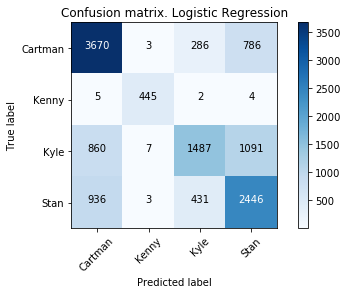

In [45]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
#import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

mat = confusion_matrix(to_train_answ, clf.predict(to_train_vec.toarray()))
plt.figure()
plot_confusion_matrix(mat, classes=['Cartman', 'Kenny' , 'Kyle' , 'Stan'],
                      title='Confusion matrix. Logistic Regression')
plt.show()

В принципе, получившаяся модель на 20-22% более эффективна, чем beseline. Если посмотреть на коэффициенты модели, то они могут быть положительными и отрицатемльными. В логистической регрессии коэффициенты имеют очень наглядный физический смысл:
в матрице, где каждое слово может встретиться в предложении (1), а может не встретиться (0), это число (1 или 0) уменожается на коэффициент. То сеть каждое встретившееся слово в предложении привносит (или отнимает)  свою долю от итогового счета.
Коэффициенты есть для каждого героя.